<a href="https://colab.research.google.com/github/kinycx/LSTM-Music-Generation/blob/main/LSTMmidiRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Music Generation 


Andremo a generare delle composizioni musicali utilizzando una rete neurale LSTM (Long Short-Term Memory).
Addestreremo la rete con **file MIDI** che contengono informazioni su note, accordi, pitch ecc. riguardanti la composizione musicale.
La nostra rete sara' in grado di generare nuovi file MIDI.


**NOTA:** I file MIDI non sono file audio.

In [ ]:
# Imposta a False se non si sta utilizzando
# questo notebook in Google Colaboratory
run_on_colab = True

 
## Reti LSTM
Le Long Short-Term Memory networks sono una tipologia di **Rete Neurale Ricorrente (RNN)**. 
Sono reti il cui output dipende dai suoi precenti. Questo loro comportamento iterativo le rende l'opzione perfetta per lavorare con sequenze (una composizione musicale altro non e' se non una sequenza di note in funzione del tempo) e liste.
 
 
Come si puo' vedere da [questo post sulle reti LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) , una RNN puo' essere vista come copie multiple della stessa rete, ognuna trasportante un messaggio alla successiva.
 
![RNN vs DNN t](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)
 
 
 
 
Il problema giunge quando si ha a che fare con le **LTD** (Long-Term Dependencies). Nonostante in teoria una RNN dovrebbe essere in grado di gestire questo gap di informazioni, alcune ricerche hanno trovato ragioni per le quali potrebbe essere difficile riuscirci. Le LSTM sono particolari RNN capaci di apprendere dalle LTD in quanto progettate per ricordare informazioni per lunghi periodi.
 
 
## Music generation
Per addestrare il modello verrano usati [file MIDI](https://it.wikipedia.org/wiki/MIDI).
Come gia' spiegato i MIDI contengono **informazioni sulla composizione**, ma non sono tracce audio. Contengono informazioni sulla notazione adottata, il pitch, la velocity, il vibrato, il panning, e segnali clock (che indicano il tempo).
 
Esistono alcuni sintetizzatori virtuali (come Ableton) che consentono di trasformare queste informazioni in vere tracce audio. Il modello apprendera' da questi file MIDI e sara' in grado di generarne nuovi da zero.
 
![MIDI file in Ableton](https://i.ytimg.com/vi/d5bmDnuOFv4/maxresdefault.jpg)

## Configurazione Google drive (per Google Colab)
Accesso all'account di **Google Drive** per utilizzare i file in Jupyter notebook.


In [ ]:
if(run_on_colab):
  from google.colab import drive
  # This will prompt for authorization.
  drive.mount("/content/drive", force_remount=True)

KeyboardInterrupt: ignored

## Librerie utilizzate e dati
Invece di utilizzare interamente i file MIDI, li elaboreremo per ottenere solo le informazioni utili allo scopo e scartare il resto. 

Per questo lavoro verra' usata la libreria [**music21**](http://web.mit.edu/music21/). Questa liberia consente di lavorare facilmente coi MIDI. 
Crea una sua rappresentazione dei MIDI, con oggetti **Note** di **Chord** che rappresentano la musica nei MIDI. E' una rappresentazione piu' facile da leggere rispetto ai MIDI e aiutera' la nostra rete a *capire* la musica e riuscire a creare nuove composizioni.

In [ ]:
!pip install music21;


### Dataset MIDI
 I  **file MIDI** sono presi da [piano-midi.de](http://www.piano-midi.de/midis/format0/) oppure da [partnersinrhyme](https://www.partnersinrhyme.com/).
 
Per una miglior accuratezza verranno utilizzate composizioni dello stesso artista. 

Ho compresso in un unico [file zip](https://drive.google.com/file/d/1DXRDETbAkBr1QHThmGMaPzTDwz_6yDov/view?usp=sharing) 50 midi con composizioni di **Chopin**

E in un altro [file zip](https://drive.google.com/file/d/1yDpMAhVV5LG9YFP74_ZatiudmvzgCxJl/view?usp=sharing) 90 composizioni di musica classica dalla saga videoludica **Final Fantasy**. presi da The
 Final
 Fantasy,
 https://thefinalfantasy.net/site/midi-
collection.html

 
Se non si utilizza colab inserire **midi_files.zip** nella directory.
 



In [ ]:
if(run_on_colab):
  from google.colab import files
  files.upload()


Saving midi_files.zip to midi_files.zip


In [ ]:
!unzip midi_files.zip;

Archive:  midi_files.zip
   creating: midi_files/
  inflating: midi_files/Finalfantasy6fanfarecomplete.mid  
  inflating: midi_files/redwings.mid  
  inflating: midi_files/ff4-town.mid  
  inflating: midi_files/mining.mid   
  inflating: midi_files/AT.mid       
  inflating: midi_files/ahead_on_our_way_piano.mid  
  inflating: midi_files/Final_Fantasy_7_-_Judgement_Day_Piano.mid  
  inflating: midi_files/Fierce_Battle_(Piano).mid  
  inflating: midi_files/traitor.mid  
  inflating: midi_files/Final_Fantasy_Matouyas_Cave_Piano.mid  
  inflating: midi_files/tifap.mid    
  inflating: midi_files/rufus.mid    
  inflating: midi_files/Gold_Silver_Rival_Battle.mid  
  inflating: midi_files/Cids.mid     
  inflating: midi_files/FF4.mid      
  inflating: midi_files/ff11_awakening_piano.mid  
  inflating: midi_files/Zelda_Overworld.mid  
  inflating: midi_files/HighwindTakestotheSkies.mid  
  inflating: midi_files/ff8-lfp.mid  
  inflating: midi_files/goldsaucer.mid  
  inflating: midi_files/V

## Elaborazione dati

Carichiamo i dati in **music21**

In [ ]:
# Dipendenze
import glob
import pickle
import numpy
import tensorflow as tf
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt


Vediamo come la libreria **music21** rappresenta la musica.
Abbiamo due elementi differenti:
- **Notes**
- **Chords**

Inoltre abbiamo il time offset di ognuno degli elementi. Questo e' il trigger (come istante di tempo) di quando la nota o l'accordo dovra' essere suonato.

In [ ]:
# esempio
file = "/content/midi_files/VincentPiano.mid"
midi = converter.parse(file)
notes_to_parse = midi.flat.notes
startSong = []

for element in notes_to_parse[:30]:

  if isinstance(element, note.Note):
      startSong.append(str(element.pitch))
  elif isinstance(element, chord.Chord):
      startSong.append('.'.join(str(n) for n in element.normalOrder))

print(startSong)

['B4', 'D5', 'F#5', 'B4', 'G5', 'F#5', 'E5', 'D5', 'E5', 'D5', 'C#5', 'D5', 'F#5', 'A5', 'D5', 'B5', 'A5', 'G5', 'F#5', 'G5', 'F#5', 'E5', 'F#5', 'G5', 'A5', 'C#5', 'E5', 'D5', 'C#5', 'D5']



Elaboreremo i file MIDI ottenendo dati per ognua delle note o accordi.

- Se viene elaborato un oggetto **note**, memorizzeremo in una lista una stringa che rappresenta il pitch (il nome della nota) e la sua ottava.

- Se viene elaborato un oggetto **chord** (gli accordi sono piu' note suonate nello stesso istante di tempo) memorizzeremo un tipo diverso di stringa con numeri separati da punti. Ogni numero rappresenta il pitch di una delle note dell'accordo. 

**Non consideriamo l'offset dei singoli elementi**.
 Questo significa che tutte le note avranno la stessa durata.

Viene crata quindi una grande lista con tutti gli elementi della composizione.

In [ ]:
notes = []
for i,file in enumerate(glob.glob("midi_files/*.mid")): # glob.glob consente di trovare tutti i path di file con estensione .mid
  midi = converter.parse(file)
  print('\r', 'Parsing file ', i, " ",file, end='')
  notes_to_parse = None
  try: # file has instrument parts
    s2 = instrument.partitionByInstrument(midi)
    notes_to_parse = s2.parts[0].recurse() # recurse consente di ottenere informazioni sulle note ignorando l'offset
  except: # file has notes in a flat structure
    notes_to_parse = midi.flat.notes
    
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      notes.append('.'.join(str(n) for n in element.normalOrder))
with open('notes', 'wb') as filepath:
  pickle.dump(notes, filepath)

 Parsing file  91   midi_files/Ff7-Jenova_Absolute.mid


Otteniamo il numero delle note e accordi nel nostro dataset perche' questo sara' il **numero delle possibili classi di output** del nostro modello.

In [ ]:
# Numero dei possibili output
n_vocab = (len(set(notes)))
n_vocab

358


Ora bisogna fare alcune elaborazioni dei dati:

- Mapperemo tutti i pitch degli accordi in un intero
- Creeremo coppie di sequenze di input e le loro note di output corrispondenti

Si possono provare diverse **sequence_length** per ottenere risultati diversi. Per adesso useremo sequence_length = 100.

La rete fara' la predizione della nota successiva (o accordo), in base alla *sequence_length* della nota (o accordo) precedente.


In [ ]:
sequence_length = 100
# prende i nomi di tutti i pitch
pitchnames = sorted(set(item for item in notes))
print(pitchnames)
# crea un dizionario per mappare i pitch agli interi
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# crea sequenze di input e i loro output corrispondenti
for i in range(0, len(notes) - sequence_length, 1):
  sequence_in = notes[i:i + sequence_length] # Size sequence_length
  sequence_out = notes[i + sequence_length]  # Size 1
  
  # Mappa i pitch di sequence_in in interi
  network_input.append([note_to_int[char] for char in sequence_in])
  # Mappa interi di sequence_out agli interi
  network_output.append(note_to_int[sequence_out])
  

print('sequence_in: ', sequence_in)
print('sequence_out: ', sequence_out)

n_patterns = len(network_input)
# reshape degli input in un formato compatibile con i layer LSTM
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
# normalizza gli input
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

['0', '0.1', '0.1.5', '0.1.6', '0.2', '0.2.3.7', '0.2.4.7', '0.2.5', '0.2.6', '0.2.7', '0.3', '0.3.5', '0.3.5.8', '0.3.6', '0.3.6.8', '0.3.6.9', '0.3.7', '0.4', '0.4.5', '0.4.6', '0.4.7', '0.5', '0.5.6', '0.6', '1', '1.2', '1.2.4.6.8.10', '1.2.6', '1.2.6.8', '1.3', '1.3.5', '1.3.5.8', '1.3.6', '1.3.7', '1.3.8', '1.4', '1.4.6', '1.4.6.9', '1.4.7', '1.4.7.10', '1.4.7.9', '1.4.8', '1.5', '1.5.8', '1.5.9', '1.6', '1.7', '10', '10.0', '10.0.2.5', '10.0.3', '10.0.4', '10.0.5', '10.1', '10.1.3', '10.1.3.5.6', '10.1.3.6', '10.1.4', '10.1.4.6', '10.1.5', '10.11', '10.11.3', '10.11.3.5', '10.2', '10.2.3', '10.2.4', '10.2.5', '10.3', '11', '11.0', '11.0.4', '11.0.4.6', '11.0.4.7', '11.0.5', '11.1', '11.1.4', '11.1.4.5', '11.1.5', '11.1.6', '11.2', '11.2.4', '11.2.4.6', '11.2.4.7', '11.2.5', '11.2.5.7', '11.2.6', '11.3', '11.3.5', '11.3.6', '11.4', '11.4.5', '2', '2.3', '2.3.7', '2.3.7.10', '2.3.7.9', '2.4', '2.4.5', '2.4.5.9', '2.4.6.9.11', '2.4.7', '2.4.7.10', '2.4.8', '2.4.9', '2.5', '2.5.7', '

Guardiamo la nuova dimensione di network_input


In [ ]:
network_input.shape

(57077, 100, 1)

## Creare il modello

Per questo modello verra' usata una rete **Stacked LSTM**.
Stacked significa che il modello sara' formato da molteplici layer nascosti, dove ognuno di essi contiene multiple celle di memoria. In questo modo il modello sara' piu' robusto.

Importante notare che return sequences avra' valore **True** (sarebbe False di default). Cio' significa che ad ogni step verra' generato un nuovo valore di output.

Creiamo la rete. Creeremo una rete di 9 layer (3 di loro **LSTM layers**).

Per regolazizzare, aggiungeremo anche 2 **layer di Dropout**

I layer di dropout sono una forma di regolarizzazione. Riducono l'over fitting simulando diverse reti neurali. Consistono nel settare una parte di input a 0 ad ogni aggiornamento dell'addestramento prevenendo l'overfitting. Questa frazione di input e' determinata dai parametri usati nel layer.

I layer LSTM sono una rete neurale ricorrente che prende una sequenza come input e puo' restituire una sequenza (return_sequences=True) o una **Matrice** come output.


I Dense layer o fully connected layer sono una rete neurale fully connected dove ogni nodo di input e' connesso ad ogni nodo di output.

Il layer di attivazione determina quale funzione di attivazione verra' usata per calcolare l'output di un nodo.


Nel codice la dimensione di ogni sequenza sara' di 100 note/accordi. Questo significa che per predirre la nota successiva nella sequenza, la rete ha le precedenti 100 note per aiutare la predizione.


Normalizzeremo l'input e faremo one-hot encoding sull'output.

One hot encoding e' una elaborazione dati dove le variabili categoriali sono convertite in un formato consono per il machine learning.


In [ ]:
def create_network(network_input, n_vocab, learning_rate):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense((256), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    rms = tf.keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer = rms, metrics='acc')
    return model


Per ogni layer LSTM, Dense e di Attivazione il primo parametro e' quanti nodi dovra' avere il layer. Per i layer di Dropout il primo parametro e' la frazione di unita' di input che dovrebbe settare a 0 durante il training.


Per il primo layer dovremo settare un parametro unico chiamato input_shape.
Serve ad informare la rete su che tipo di forma avranno i dati su cui verra' addestrata.

Il numero di nodi dell'ultimo layer dovrebbero essere gli stessi del numero di output del nostro sistema. In questo modo ci assicuriamo che gli output della rete verranno mappati alle classi.


Per calcolare il valore di loss ad ogni iterazione dell'addestramento useremo *categorical cross entropy* siccome ognuno dei nostri output appartiene ad una singola classe e dovremo lavorare con piu' classi. Per ottimizzare la rete useremo **RMSprop optimizer** che e' generalmente un'ottima scelta pere le RNN.

In [ ]:
learning_rate = 0.0005 
model = create_network(network_input,n_vocab, learning_rate)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

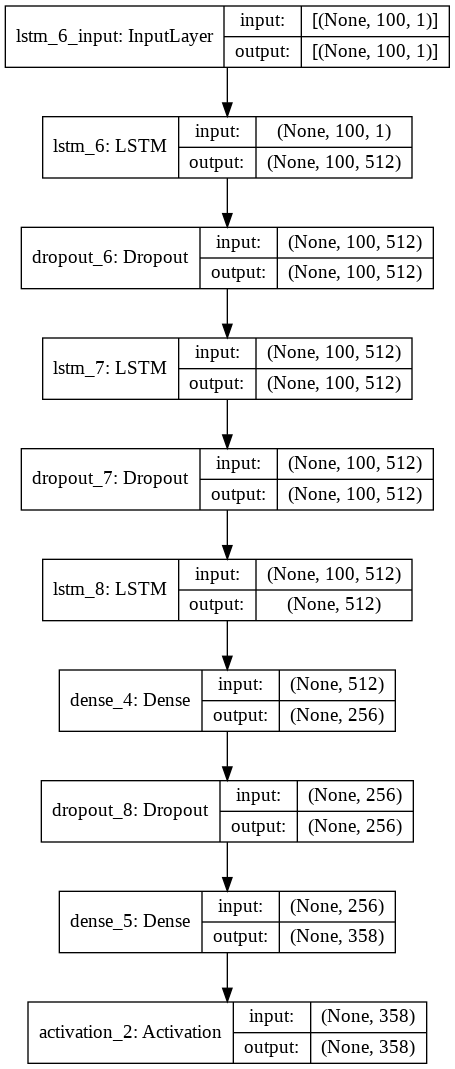

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In caso volessimo utilizzare pesi precedentemente addestrati per continuare l'addestramento da dove era stato interrotto dovremmo caricarli nel modello.

Molto utile in Google Colaboratory, che solitamente interrompe l'esecuzione dopo un certo ammontare di tempo.

In [ ]:
# Inserire un path a un weight pre-addestrato
weights = ''
if(len(weights)>2): model.load_weights(weights)

Utilizzeremo **ModelCheckpoint**.

ModelCheckpoint salvera' i nostri in un file dopo ogni epoch terminata.

In questo modo e' possibile riprendere l'addestramento anche dopo che esso e' stato interrotto.

Si puo' addestrare la rete per quante epochs si vuole. Con circa **70 epochs** la rete e' capace di comporre musica accettabile. Non serve un valore di loss molto basso, 0.7 o 0.8 va bene. 


In [ ]:
from pathlib import Path

data_folder = Path("/content/drive/MyDrive/checkpoints/" + str(sequence_length)) 
filepath = data_folder / "{epoch:02d}-{loss:.4f}.h5"
 
checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=0,
                             save_best_only=True, mode='min')
 
callbacks_list = [checkpoint]

history = model.fit(network_input, network_output, epochs=300,  batch_size=64, callbacks=callbacks_list) # validation_split per val_accuracy e val_loss

Epoch 1/300
 14/892 [..............................] - ETA: 1:34 - loss: 5.6863 - acc: 0.0112

KeyboardInterrupt: ignored

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Generazione della Musica

Si puo' utilizzare un weight pre-addestrato come [questo](https://drive.google.com/file/d/1UgCa_4LPxw_6cYMxnYeS555TEQg8tRQ1/view?usp=sharing)

In [ ]:
# Per utilizzare il weight addestrato
weights = "/content/drive/MyDrive/musGen/weight100SL/300-0.2556.h5" # modificare il numero in base all'epoca scelta
if(len(weights)>0): model.load_weights(weights)

In [ ]:
# Generiamo un network input di nuovo
network_input = []
output = []
for i in range(0, len(notes) - sequence_length, 1):
  sequence_in = notes[i:i + sequence_length]
  sequence_out = notes[i + sequence_length]
  network_input.append([note_to_int[char] for char in sequence_in])
  output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
len(network_input)

57077

Ora bisogna:


1.   Selezionare una **seed sequence** casuale dalla lista di input (variabile *pattern*)
2.   Passarlo come input per il modello per generare un nuovo elemento (nota o accordo)
3.   Aggiungere il nuovo elemento alla composizione finale e nella *pattern* list
4.   Rimuovere il primo elemento da *pattern*
5.   Ripetere dal punto 2




In [ ]:
""" Generiamo le nota dalla rete neutale basata su una sequenza di note"""
# scegliamo una sequenza casuale dall'input come punto di partenza per le predizioni successive
start = numpy.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# genera 500 note

for i,note_index in enumerate(range(500)):
  prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
  prediction_input = prediction_input / float(n_vocab)
  prediction = model.predict(prediction_input, verbose=0)
  index = numpy.argmax(prediction)
  result = int_to_note[index]
  print('\r', 'Predicted ', i, " ",result, " ", end='')
  prediction_output.append(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]


In [ ]:
""" Generiamo le nota dalla rete neutale basata su una sequenza di note"""
# scegliamo una sequenza di 30 note da un midi del dataset come punto di partenza per le predizioni successive
start = numpy.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = startSong
# genera 470 note dopo le prime 30 inserite

for i,note_index in enumerate(range(470)):
  prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
  prediction_input = prediction_input / float(n_vocab)
  prediction = model.predict(prediction_input, verbose=0)
  index = numpy.argmax(prediction)
  result = int_to_note[index]
  print('\r', 'Predicted ', i, " ",result, " ", end='')
  prediction_output.append(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]

print(start)

 Predicted  169   G4  33314



Scegliamo di generare 500 note che sono circa 2 minuti di musica. Per ogni nota che vogliamo generare dobbiamo dare alla rete una sequenza.


La prima sequenza che diamo e' la sequenza di note all'inizio dell'indice.
Per ogni sequenza seguente che usiamo come input, rimuoviamo la prima nota della sequenza e inseriamo l'output della iterazione precedente alla fine della sequenza.



![Sequenza](https://miro.medium.com/max/486/1*lsMVJ484dEqIVMFyJ1gV2g.jpeg)




Per determinare la nota piu' probabile dall'output della rete, estrapoliamo l'indice del valore piu' alto. Il valore all'indice X nell'array di output corrisponde alla probabilita' che X sia la prossima nota.

![Prediction](https://miro.medium.com/max/621/1*YpnnaPA1Sm8rzTR4N2knKQ.jpeg)


Poi raggruppiamo tutti gli output dalla rete in un singolo array.

## Creazione del MIDI

Ora che abbiamo codificato la rappresentazione delle note e degli accordi in un array possiamo decodificarli e creare un arrati di oggetti **Note** e **Chord**.

Prima dobbiamo determinare se l'output che stiamo decodificando e' una Nota o un Accordo.


Se il pattern e' un accordo, dobbiamo dividere la stringa in un array di note. Poi cicliamo sulla stringa di rappresentazione delle note e creiamo un oggetto **Note** per ognuna di esse. Successivamente possiamo creare un oggetto **Chord** contenente ognuna di queste note.


Se il pattern e' una nota, creiamo un oggetto **Note** usando la stringa di rappresentazione del pitch contenunto nel pattern.

Il prossimo step e' creare un file MIDI.

**music21** ci aiuta in questa operazione. Bisogna creare uno **Stream** e aggiungerlo alle note e accordi predetti.

L'offset tra gli elementi sara' 0.5.

In [ ]:
offset = 0
output_notes = []
# crea oggetti note e chord basati sui valori generati dal modello
for pattern in prediction_output:
    # se pattern e' un oggetto chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # se pattern e' un oggetto note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # aumenta l'offset di ogni iterazione 
    offset += 0.5

midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='/content/drive/MyDrive/musGen/output100/vincentComp.mid')

'/content/drive/MyDrive/musGen/output100/confrontoCave.mid'

In [ ]:
def playmidi(path):
  mf = midi.MidiFile()
  mf.open(path) 
  mf.read()
  mf.close()
  s = midi.translate.midiFileToStream(mf)
  s.show('midi')

In [ ]:
playmidi('/content/drive/My Drive/musGen/test_output_FF.mid')